In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import re
import nltk
from nltk import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
nltk.download('stopwords')
nltk.download('wordnet')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
import autokeras as ak
from sklearn.model_selection import KFold

import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ddayv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ddayv\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
df = pd.read_csv("tash-pt.csv")
df

,id_twitter,sentiment,text
0,1067856049821155334,1,@tchaugip @n00bona História vence técnica faci...
1,1070902848957964288,1,@camandis aa obrigado perfeito o seu timing ti...
2,1073158858925838336,0,moldura artística favorita entre filistinos al...
3,1073220881344856064,0,Minha cama tá no localizada no meio nesse mome...
4,1073347140334833664,0,@eueduramos o mundo so vai mudar quando as pes...
...,...,...,...
2782,1068599890761129985,-1,@PastorMalafaia Concordo com Prof Olavo de Car...
2783,1071376463230840833,-1,@ClaudiaLeitte se o clipe de saudade não for g...
2784,1073978880787181568,1,agr o ar vai ficar ligado 24 por 48
2785,1074925265980145666,0,e eu que no meio de tantos problemas ainda con...


In [3]:
df.isnull().sum()
df = df.dropna()

In [4]:
df = df.drop(columns=['id_twitter'])
df['sentiment'].unique()

array([ 1,  0, -1], dtype=int64)

In [5]:
df['sentiment'].value_counts()

 0    1018
 1     888
-1     881
Name: sentiment, dtype: int64

In [6]:
Tweet = df['text']
sentiment = np.asarray(df['sentiment'])

In [7]:
count_vect = CountVectorizer()
X_train = count_vect.fit_transform(Tweet)

tfidf_transformer = TfidfTransformer()
X_train_transform = tfidf_transformer.fit_transform(X_train) # Aplicando o TF-IDF
X_train_transform.shape

(2787, 12712)

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train_transform, sentiment, test_size=0.3)

clf = MultinomialNB().fit(X_train, Y_train) # Aplicando naive bayes
predicted = clf.predict(X_test)

print(classification_report(Y_test, predicted))

              precision    recall  f1-score   support

          -1       0.46      0.46      0.46       254
           0       0.42      0.57      0.48       312
           1       0.45      0.28      0.34       271

    accuracy                           0.44       837
   macro avg       0.45      0.44      0.43       837
weighted avg       0.45      0.44      0.43       837



In [11]:
kf = KFold(n_splits=10)
clf = MultinomialNB()
lista = []
for train_index, test_index in kf.split(X_train_transform):
    X_train, X_test = X_train_transform[train_index], X_train_transform[test_index]
    y_train, y_test = sentiment[train_index], sentiment[test_index]
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    lista.append(clf.score(X_test, y_test))
    
    print(clf.score(X_test, y_test))
    
print(f' Média: {np.array(lista).mean()} \t Std: {np.array(lista).std()}  ')

0.4229390681003584
0.43727598566308246
0.4121863799283154
0.4265232974910394
0.4838709677419355
0.4731182795698925
0.45878136200716846
0.44244604316546765
0.4352517985611511
0.4784172661870504
 Média: 0.44708104484154604 	 Std: 0.02372960041678921  


In [12]:
def pre_X(frases):
    lista = []
    
    for frase in frases:
        lista.append(frase)
    return lista

def pre_Y(number):
    lista = []
    
    for numb in number:
        lista.append(numb)
    return lista

In [13]:
#pré-processamento dos textos
def set_array(frases):
    
    vocab = []
    palavras = []
    for frase in frases:
        text_array = remove_user(frase)
        text_array = Tokenize(text_array)
        text_array = text_array.split(' ')
        for i in range(len(text_array)):
            vocab.append(text_array[i])
    return vocab

def Tokenize(f):  

    f = f.lower().replace('\n', '').replace('-','').replace('#','').replace('.','').replace(',','').replace('!','').replace('r\n','').replace('  ','')
    token = RegexpTokenizer(r"\w+")
    f = token.tokenize(f)
    stop_words = set(stopwords.words('portuguese'))
    new_word = [word for word in f if not word in stop_words]
    return ' '.join(new_word)

def remove_user(frase):
    return re.sub('@\w+','',frase)

In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(10, activation='tanh'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3 , activation='softmax')
])

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.categorical_crossentropy,
    metrics=['accuracy']
)

In [15]:
Tweet = Tweet.apply(remove_user)
Tweet_preprocessed = Tweet.apply(Tokenize)

In [16]:
count_vect = CountVectorizer()
X_train = count_vect.fit_transform(Tweet_preprocessed)

tfidf_transformer = TfidfTransformer()
X_train_transform = tfidf_transformer.fit_transform(X_train) # Aplicando o TF-IDF


X_train, X_test, Y_train, Y_test = train_test_split(X_train_transform, sentiment, test_size=0.3)

X_train

<1950x11553 sparse matrix of type '<class 'numpy.float64'>'
	with 23927 stored elements in Compressed Sparse Row format>

In [17]:
X_test

<837x11553 sparse matrix of type '<class 'numpy.float64'>'
	with 10374 stored elements in Compressed Sparse Row format>

In [18]:
one = OneHotEncoder(sparse=False)

In [19]:
y_one = one.fit_transform(Y_train.reshape(-1,1))
y_one_ = one.transform(Y_test.reshape(-1,1))

In [20]:
fit = model.fit(X_train.todense(), y_one, epochs=10, validation_data=(X_test.todense(), y_one_))

Epoch 1/10
61/61 [==============================] - 0s 7ms/step - loss: 1.0968 - accuracy: 0.3554 - val_loss: 1.0963 - val_accuracy: 0.3632
Epoch 2/10
61/61 [==============================] - 0s 5ms/step - loss: 1.0721 - accuracy: 0.4267 - val_loss: 1.0830 - val_accuracy: 0.3787
Epoch 3/10
61/61 [==============================] - 0s 5ms/step - loss: 0.8989 - accuracy: 0.6826 - val_loss: 1.0778 - val_accuracy: 0.4277
Epoch 4/10
61/61 [==============================] - 0s 5ms/step - loss: 0.5435 - accuracy: 0.8344 - val_loss: 1.2031 - val_accuracy: 0.4313
Epoch 5/10
61/61 [==============================] - 0s 5ms/step - loss: 0.2643 - accuracy: 0.9359 - val_loss: 1.3849 - val_accuracy: 0.4444
Epoch 6/10
61/61 [==============================] - 0s 5ms/step - loss: 0.1257 - accuracy: 0.9779 - val_loss: 1.6006 - val_accuracy: 0.4229
Epoch 7/10
61/61 [==============================] - 0s 5ms/step - loss: 0.0668 - accuracy: 0.9908 - val_loss: 1.7504 - val_accuracy: 0.4265
Epoch 8/10
61/61 [==

In [21]:
predicted = model.predict(X_test.todense())

print(classification_report(np.argmax(y_one_, axis=1), np.argmax(predicted, axis=1)))

              precision    recall  f1-score   support

           0       0.45      0.40      0.43       272
           1       0.44      0.41      0.43       304
           2       0.36      0.43      0.40       261

    accuracy                           0.42       837
   macro avg       0.42      0.42      0.42       837
weighted avg       0.42      0.42      0.42       837



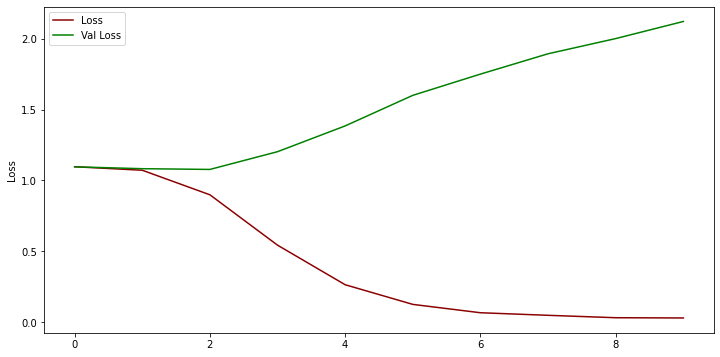

In [22]:
plt.figure(figsize=(12,6))
plt.plot(fit.history['loss'], label='Loss', color='darkred')
plt.plot(fit.history['val_loss'], label='Val Loss', color='green')
plt.legend()
plt.ylabel('Loss')
plt.show()

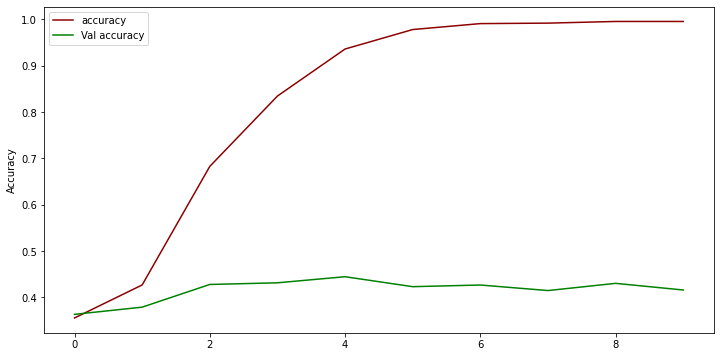

In [23]:
plt.figure(figsize=(12,6))
plt.plot(fit.history['accuracy'], label='accuracy', color='darkred')
plt.plot(fit.history['val_accuracy'], label='Val accuracy', color='green')
plt.legend()
plt.ylabel('Accuracy')
plt.show()

In [24]:
kf = KFold(n_splits=10)
val_accuracy = []
index = []
cont = 0

for train_index, test_index in kf.split(X_train_transform):
    cont += 1
    
    model = tf.keras.Sequential([
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(10, activation='tanh'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3 , activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.categorical_crossentropy,
        metrics=['accuracy']
    )
    
    X_train, X_test = X_train_transform[train_index], X_train_transform[test_index]
    y_train, y_test = sentiment[train_index], sentiment[test_index]
    y_train_one = one.fit_transform(y_train.reshape(-1,1))
    y_teste_one = one.fit_transform(y_test.reshape(-1,1))
    
    print("Iter: ",cont)
    print(" ")
    
    fit = model.fit(X_train.todense(), y_train_one, epochs=5, validation_data=(X_test.todense(), y_teste_one))
    print(" ")
    val_accuracy.append(fit.history['val_accuracy'])
    
    index.append((train_index,test_index))

Iter:  1
 
Epoch 1/5
79/79 [==============================] - 0s 5ms/step - loss: 1.0950 - accuracy: 0.3732 - val_loss: 1.1189 - val_accuracy: 0.2545
Epoch 2/5
79/79 [==============================] - 0s 4ms/step - loss: 1.0640 - accuracy: 0.3951 - val_loss: 1.0931 - val_accuracy: 0.3333
Epoch 3/5
79/79 [==============================] - 0s 4ms/step - loss: 0.8610 - accuracy: 0.6818 - val_loss: 1.0648 - val_accuracy: 0.4731
Epoch 4/5
79/79 [==============================] - 0s 4ms/step - loss: 0.4441 - accuracy: 0.8784 - val_loss: 1.2324 - val_accuracy: 0.4444
Epoch 5/5
79/79 [==============================] - 0s 4ms/step - loss: 0.2036 - accuracy: 0.9553 - val_loss: 1.4517 - val_accuracy: 0.4552
 
Iter:  2
 
Epoch 1/5
79/79 [==============================] - 0s 6ms/step - loss: 1.0977 - accuracy: 0.3473 - val_loss: 1.0942 - val_accuracy: 0.3978
Epoch 2/5
79/79 [==============================] - 0s 5ms/step - loss: 1.0522 - accuracy: 0.4665 - val_loss: 1.0730 - val_accuracy: 0.4265
Epo

In [25]:
def media_std(val_accuracy):
    matrix_acc = np.array(val_accuracy)
    lista = []
    for i in range(len(matrix_acc)):
        lista.append(matrix_acc[i][-1])
        print(f' Fold: {i}\t Ultimo valor acc: {lista[i]}')
    print("")
    print(f' Média: {np.array(lista).mean()} \t Std: {np.array(lista).std()}')
        
media_std(val_accuracy)

 Fold: 0	 Ultimo valor acc: 0.45519712567329407
 Fold: 1	 Ultimo valor acc: 0.4193548262119293
 Fold: 2	 Ultimo valor acc: 0.39426523447036743
 Fold: 3	 Ultimo valor acc: 0.4444444477558136
 Fold: 4	 Ultimo valor acc: 0.4301075339317322
 Fold: 5	 Ultimo valor acc: 0.4444444477558136
 Fold: 6	 Ultimo valor acc: 0.44802868366241455
 Fold: 7	 Ultimo valor acc: 0.38129496574401855
 Fold: 8	 Ultimo valor acc: 0.384892076253891
 Fold: 9	 Ultimo valor acc: 0.4460431635379791

 Média: 0.42480725049972534 	 Std: 0.026762210752962822


In [26]:
vectorize_layer = TextVectorization(
 max_tokens=15000,
 output_mode='int',
 output_sequence_length=len(max(df['text'])))

vocab = set_array(df['text'])

vectorize_layer.adapt(np.unique(vocab))
len(vectorize_layer.get_vocabulary())


11590

## CONV1D

In [37]:
model = tf.keras.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(
        input_dim=len(vectorize_layer.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    
    tf.keras.layers.Conv1D(32,6, activation='relu'),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')   
])

model.compile(
    optimizer= tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.categorical_crossentropy,
    metrics=['accuracy']
)

In [38]:
X_train, X_test, Y_train, Y_test = train_test_split(Tweet_preprocessed, sentiment, test_size=0.3)

In [39]:
y_one = one.fit_transform(Y_train.reshape(-1,1))
y_one_ = one.transform(Y_test.reshape(-1,1))

In [40]:
fit = model.fit(np.asarray(pre_X(X_train)), y_one, epochs=10, batch_size=128 ,validation_data=(np.asarray(pre_X(X_test)),y_one_))

Epoch 1/10
16/16 [==============================] - 0s 27ms/step - loss: 1.0991 - accuracy: 0.3405 - val_loss: 1.0953 - val_accuracy: 0.3955
Epoch 2/10
16/16 [==============================] - 0s 17ms/step - loss: 1.0857 - accuracy: 0.3549 - val_loss: 1.0915 - val_accuracy: 0.3955
Epoch 3/10
16/16 [==============================] - 0s 20ms/step - loss: 1.0498 - accuracy: 0.4954 - val_loss: 1.0913 - val_accuracy: 0.4086
Epoch 4/10
16/16 [==============================] - 0s 17ms/step - loss: 0.9434 - accuracy: 0.8554 - val_loss: 1.0869 - val_accuracy: 0.3955
Epoch 5/10
16/16 [==============================] - 0s 19ms/step - loss: 0.7160 - accuracy: 0.9210 - val_loss: 1.0780 - val_accuracy: 0.4002
Epoch 6/10
16/16 [==============================] - 0s 18ms/step - loss: 0.4133 - accuracy: 0.9569 - val_loss: 1.1196 - val_accuracy: 0.3859
Epoch 7/10
16/16 [==============================] - 0s 22ms/step - loss: 0.1893 - accuracy: 0.9903 - val_loss: 1.1448 - val_accuracy: 0.3907
Epoch 8/10
16

In [42]:
predicted = model.predict(X_test)

print(classification_report(np.argmax(y_one_, axis=1), np.argmax(predicted, axis=1)))

              precision    recall  f1-score   support

           0       0.34      0.47      0.40       239
           1       0.42      0.30      0.35       331
           2       0.35      0.36      0.36       267

    accuracy                           0.37       837
   macro avg       0.37      0.38      0.37       837
weighted avg       0.37      0.37      0.36       837



In [43]:
kf = KFold(n_splits=10)
val_accuracy = []
index = []
cont = 0

for train_index, test_index in kf.split(Tweet_preprocessed):
    cont += 1
    
    model = tf.keras.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(
        input_dim=len(vectorize_layer.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    
    tf.keras.layers.Conv1D(32,6, activation='relu'),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')   
    ])

    model.compile(
    optimizer= tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.categorical_crossentropy,
    metrics=['accuracy']
    )
    
    X_train, X_test = Tweet_preprocessed[train_index], Tweet_preprocessed[test_index]
    y_train, y_test = sentiment[train_index], sentiment[test_index]
    y_train_one = one.fit_transform(y_train.reshape(-1,1))
    y_teste_one = one.fit_transform(y_test.reshape(-1,1))
    
    print("Iter: ",cont)
    print(" ")
    
    fit = model.fit(X_train, y_train_one, epochs=5, validation_data=(X_test, y_teste_one))
    print(" ")
    val_accuracy.append(fit.history['val_accuracy'])
    
    index.append((train_index,test_index))

Iter:  1
 
Epoch 1/5
79/79 [==============================] - 1s 10ms/step - loss: 1.0959 - accuracy: 0.3660 - val_loss: 1.1224 - val_accuracy: 0.2545
Epoch 2/5
79/79 [==============================] - 1s 10ms/step - loss: 0.9892 - accuracy: 0.5195 - val_loss: 1.1370 - val_accuracy: 0.3082
Epoch 3/5
79/79 [==============================] - 1s 11ms/step - loss: 0.5586 - accuracy: 0.7444 - val_loss: 1.2958 - val_accuracy: 0.3656
Epoch 4/5
79/79 [==============================] - 1s 10ms/step - loss: 0.2732 - accuracy: 0.9286 - val_loss: 1.4073 - val_accuracy: 0.3943
Epoch 5/5
79/79 [==============================] - 1s 9ms/step - loss: 0.0895 - accuracy: 0.9860 - val_loss: 1.6374 - val_accuracy: 0.4158
 
Iter:  2
 
Epoch 1/5
79/79 [==============================] - 1s 11ms/step - loss: 1.0976 - accuracy: 0.3549 - val_loss: 1.0929 - val_accuracy: 0.3978
Epoch 2/5
79/79 [==============================] - 1s 10ms/step - loss: 0.9959 - accuracy: 0.5614 - val_loss: 1.1077 - val_accuracy: 0.35

In [44]:
media_std(val_accuracy)

 Fold: 0	 Ultimo valor acc: 0.41577062010765076
 Fold: 1	 Ultimo valor acc: 0.379928320646286
 Fold: 2	 Ultimo valor acc: 0.40143370628356934
 Fold: 3	 Ultimo valor acc: 0.3476702570915222
 Fold: 4	 Ultimo valor acc: 0.4444444477558136
 Fold: 5	 Ultimo valor acc: 0.379928320646286
 Fold: 6	 Ultimo valor acc: 0.379928320646286
 Fold: 7	 Ultimo valor acc: 0.3525179922580719
 Fold: 8	 Ultimo valor acc: 0.3884892165660858
 Fold: 9	 Ultimo valor acc: 0.3201438784599304

 Média: 0.3810255080461502 	 Std: 0.03367019710445899


## BDR

In [45]:
model = tf.keras.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(
        input_dim=len(vectorize_layer.get_vocabulary()),
        output_dim=64,mask_zero=True),
    
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50)),
    
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(
    optimizer= tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.categorical_crossentropy,
    metrics=['accuracy']
)

In [46]:
X_train, X_test, Y_train, Y_test = train_test_split(Tweet_preprocessed, sentiment, test_size=0.3)

In [47]:
y_one = one.fit_transform(Y_train.reshape(-1,1))
y_one_ = one.transform(Y_test.reshape(-1,1))

In [48]:
fit = model.fit(np.asarray(pre_X(X_train)), y_one, epochs=10, batch_size=128 ,validation_data=(np.asarray(pre_X(X_test)),y_one_))

Epoch 1/10
16/16 [==============================] - 3s 199ms/step - loss: 1.0968 - accuracy: 0.3667 - val_loss: 1.0975 - val_accuracy: 0.3417
Epoch 2/10
16/16 [==============================] - 1s 86ms/step - loss: 1.0741 - accuracy: 0.3754 - val_loss: 1.0934 - val_accuracy: 0.3417
Epoch 3/10
16/16 [==============================] - 1s 79ms/step - loss: 0.9654 - accuracy: 0.4933 - val_loss: 1.0995 - val_accuracy: 0.4146
Epoch 4/10
16/16 [==============================] - 1s 84ms/step - loss: 0.5773 - accuracy: 0.8754 - val_loss: 1.7090 - val_accuracy: 0.4170
Epoch 5/10
16/16 [==============================] - 1s 88ms/step - loss: 0.2498 - accuracy: 0.9605 - val_loss: 2.0743 - val_accuracy: 0.4265
Epoch 6/10
16/16 [==============================] - 1s 84ms/step - loss: 0.1204 - accuracy: 0.9821 - val_loss: 2.6661 - val_accuracy: 0.4205
Epoch 7/10
16/16 [==============================] - 1s 84ms/step - loss: 0.0669 - accuracy: 0.9903 - val_loss: 3.1340 - val_accuracy: 0.4098
Epoch 8/10
1

In [50]:
predicted = model.predict(X_test)

print(classification_report(np.argmax(y_one_, axis=1), np.argmax(predicted, axis=1)))

              precision    recall  f1-score   support

           0       0.44      0.47      0.45       278
           1       0.40      0.30      0.35       286
           2       0.38      0.45      0.41       273

    accuracy                           0.41       837
   macro avg       0.41      0.41      0.40       837
weighted avg       0.41      0.41      0.40       837



In [51]:
kf = KFold(n_splits=10)
val_accuracy = []
index = []
cont = 0

for train_index, test_index in kf.split(Tweet_preprocessed):
    cont += 1
    
    model = tf.keras.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(
        input_dim=len(vectorize_layer.get_vocabulary()),
        output_dim=64,mask_zero=True),
    
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50)),
    
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
    
    ])

    model.compile(
        
    optimizer= tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.categorical_crossentropy,
    metrics=['accuracy']
        
    )
    
    X_train, X_test = Tweet_preprocessed[train_index], Tweet_preprocessed[test_index]
    y_train, y_test = sentiment[train_index], sentiment[test_index]
    y_train_one = one.fit_transform(y_train.reshape(-1,1))
    y_teste_one = one.fit_transform(y_test.reshape(-1,1))
    
    print("Iter: ",cont)
    print(" ")
    
    fit = model.fit(X_train, y_train_one, epochs=5, validation_data=(X_test, y_teste_one))
    print(" ")
    val_accuracy.append(fit.history['val_accuracy'])
    
    index.append((train_index,test_index))

Iter:  1
 
Epoch 1/5
79/79 [==============================] - 4s 56ms/step - loss: 1.0952 - accuracy: 0.3700 - val_loss: 1.1056 - val_accuracy: 0.2545
Epoch 2/5
79/79 [==============================] - 3s 38ms/step - loss: 0.8979 - accuracy: 0.6025 - val_loss: 1.1874 - val_accuracy: 0.4265
Epoch 3/5
79/79 [==============================] - 3s 35ms/step - loss: 0.3146 - accuracy: 0.9055 - val_loss: 1.5802 - val_accuracy: 0.4516
Epoch 4/5
79/79 [==============================] - 3s 35ms/step - loss: 0.0977 - accuracy: 0.9749 - val_loss: 2.1116 - val_accuracy: 0.4516
Epoch 5/5
79/79 [==============================] - 3s 34ms/step - loss: 0.0385 - accuracy: 0.9912 - val_loss: 2.4603 - val_accuracy: 0.4624
 
Iter:  2
 
Epoch 1/5
79/79 [==============================] - 4s 50ms/step - loss: 1.0932 - accuracy: 0.3620 - val_loss: 1.0761 - val_accuracy: 0.4409
Epoch 2/5
79/79 [==============================] - 3s 34ms/step - loss: 0.9010 - accuracy: 0.5682 - val_loss: 1.1430 - val_accuracy: 0.4

In [52]:
media_std(val_accuracy)

 Fold: 0	 Ultimo valor acc: 0.46236559748649597
 Fold: 1	 Ultimo valor acc: 0.4050179123878479
 Fold: 2	 Ultimo valor acc: 0.3978494703769684
 Fold: 3	 Ultimo valor acc: 0.3655914068222046
 Fold: 4	 Ultimo valor acc: 0.4301075339317322
 Fold: 5	 Ultimo valor acc: 0.4301075339317322
 Fold: 6	 Ultimo valor acc: 0.3870967626571655
 Fold: 7	 Ultimo valor acc: 0.3884892165660858
 Fold: 8	 Ultimo valor acc: 0.3956834673881531
 Fold: 9	 Ultimo valor acc: 0.4460431635379791

 Média: 0.4108352065086365 	 Std: 0.028600228122043644


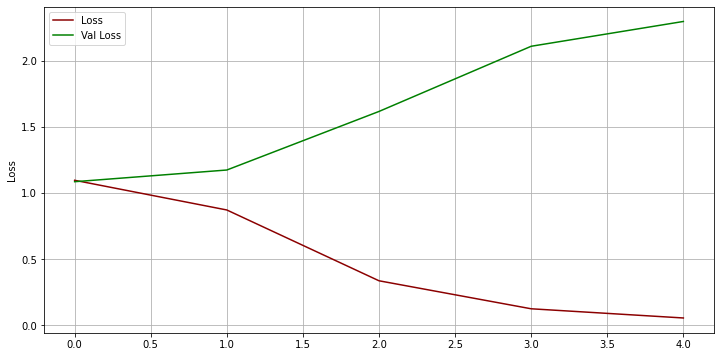

In [53]:
plt.figure(figsize=(12,6))
plt.plot(fit.history['loss'], label='Loss', color='darkred')
plt.plot(fit.history['val_loss'], label='Val Loss', color='green')
plt.legend()
plt.grid()
plt.ylabel('Loss')
plt.show()

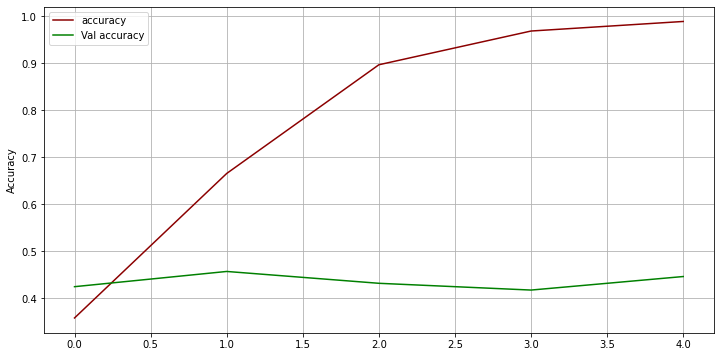

In [54]:
plt.figure(figsize=(12,6))
plt.plot(fit.history['accuracy'], label='accuracy', color='darkred')
plt.plot(fit.history['val_accuracy'], label='Val accuracy', color='green')
plt.legend()
plt.grid()
plt.ylabel('Accuracy')
plt.show()

## LSTM

In [55]:
model = tf.keras.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(
        input_dim=len(vectorize_layer.get_vocabulary()),
        output_dim=64,mask_zero=True),
    
    tf.keras.layers.LSTM(50, activation='relu' ,return_sequences=True),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.LSTM(10 , activation='tanh'),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(3, activation='softmax')
    ])

model.compile(
    optimizer= tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.categorical_crossentropy,
    metrics=['accuracy']
)

In [56]:
X_train, X_test, Y_train, Y_test = train_test_split(Tweet_preprocessed, sentiment, test_size=0.3)

In [57]:
y_one = one.fit_transform(Y_train.reshape(-1,1))
y_one_ = one.transform(Y_test.reshape(-1,1))

In [58]:
fit = model.fit(np.asarray(pre_X(X_train)), y_one, epochs=10, batch_size=128 ,validation_data=(np.asarray(pre_X(X_test)),y_one_))

Epoch 1/10
16/16 [==============================] - 4s 258ms/step - loss: 1.0973 - accuracy: 0.3456 - val_loss: 1.0959 - val_accuracy: 0.3620
Epoch 2/10
16/16 [==============================] - 2s 154ms/step - loss: 1.0884 - accuracy: 0.3667 - val_loss: 1.0934 - val_accuracy: 0.3620
Epoch 3/10
16/16 [==============================] - 2s 147ms/step - loss: 1.0596 - accuracy: 0.4056 - val_loss: 1.0822 - val_accuracy: 0.3883
Epoch 4/10
16/16 [==============================] - 3s 178ms/step - loss: 0.8860 - accuracy: 0.6497 - val_loss: 1.1403 - val_accuracy: 0.4325
Epoch 5/10
16/16 [==============================] - 3s 180ms/step - loss: 0.6325 - accuracy: 0.8533 - val_loss: 1.3631 - val_accuracy: 0.4110
Epoch 6/10
16/16 [==============================] - 3s 184ms/step - loss: 0.3978 - accuracy: 0.9164 - val_loss: 1.7682 - val_accuracy: 0.4026
Epoch 7/10
16/16 [==============================] - 3s 201ms/step - loss: 0.3057 - accuracy: 0.9359 - val_loss: 1.9006 - val_accuracy: 0.3978
Epoch 

In [59]:
predicted = model.predict(X_test)

print(classification_report(np.argmax(y_one_, axis=1), np.argmax(predicted, axis=1)))

              precision    recall  f1-score   support

           0       0.42      0.46      0.44       260
           1       0.45      0.38      0.41       303
           2       0.39      0.43      0.41       274

    accuracy                           0.42       837
   macro avg       0.42      0.42      0.42       837
weighted avg       0.42      0.42      0.42       837



In [60]:
kf = KFold(n_splits=10)
val_accuracy = []
index = []
cont = 0

for train_index, test_index in kf.split(Tweet_preprocessed):
    cont += 1
    
    model = tf.keras.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(
        input_dim=len(vectorize_layer.get_vocabulary()),
        output_dim=64,mask_zero=True),
    
    tf.keras.layers.LSTM(50, activation='relu' ,return_sequences=True),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.LSTM(10 , activation='tanh'),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(3, activation='softmax')
    ])

    model.compile(
        optimizer= tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.categorical_crossentropy,
        metrics=['accuracy']
    )
    
    X_train, X_test = Tweet_preprocessed[train_index], Tweet_preprocessed[test_index]
    y_train, y_test = sentiment[train_index], sentiment[test_index]
    y_train_one = one.fit_transform(y_train.reshape(-1,1))
    y_teste_one = one.fit_transform(y_test.reshape(-1,1))
    
    print("Iter: ",cont)
    print(" ")
    
    fit = model.fit(X_train, y_train_one, epochs=5, validation_data=(X_test, y_teste_one))
    print(" ")
    val_accuracy.append(fit.history['val_accuracy'])
    
    index.append((train_index,test_index))

Iter:  1
 
Epoch 1/5
79/79 [==============================] - 6s 80ms/step - loss: 1.0943 - accuracy: 0.3680 - val_loss: 1.1176 - val_accuracy: 0.2545
Epoch 2/5
79/79 [==============================] - 5s 64ms/step - loss: 1.0172 - accuracy: 0.4860 - val_loss: 1.1124 - val_accuracy: 0.3835
Epoch 3/5
79/79 [==============================] - 5s 62ms/step - loss: 0.6372 - accuracy: 0.7807 - val_loss: 1.2164 - val_accuracy: 0.4588
Epoch 4/5
79/79 [==============================] - 5s 61ms/step - loss: 0.2999 - accuracy: 0.9147 - val_loss: 1.4908 - val_accuracy: 0.4624
Epoch 5/5
79/79 [==============================] - 5s 64ms/step - loss: 0.1645 - accuracy: 0.9589 - val_loss: 1.8743 - val_accuracy: 0.4624
 
Iter:  2
 
Epoch 1/5
79/79 [==============================] - 6s 79ms/step - loss: 1.0966 - accuracy: 0.3557 - val_loss: 1.0917 - val_accuracy: 0.3978
Epoch 2/5
79/79 [==============================] - 5s 60ms/step - loss: 0.9965 - accuracy: 0.5243 - val_loss: 1.1384 - val_accuracy: 0.3

In [61]:
media_std(val_accuracy)

 Fold: 0	 Ultimo valor acc: 0.46236559748649597
 Fold: 1	 Ultimo valor acc: 0.3978494703769684
 Fold: 2	 Ultimo valor acc: 0.38351255655288696
 Fold: 3	 Ultimo valor acc: 0.4301075339317322
 Fold: 4	 Ultimo valor acc: 0.4229390621185303
 Fold: 5	 Ultimo valor acc: 0.4265232980251312
 Fold: 6	 Ultimo valor acc: 0.41577062010765076
 Fold: 7	 Ultimo valor acc: 0.39208632707595825
 Fold: 8	 Ultimo valor acc: 0.3884892165660858
 Fold: 9	 Ultimo valor acc: 0.37050360441207886

 Média: 0.4090147286653519 	 Std: 0.026083133753362603


In [20]:
TextClassifier = ak.TextClassifier(
    num_classes=3, 
    multi_label=True, 
    loss=tf.keras.losses.categorical_crossentropy, 
    metrics=['accuracy'],
    project_name="text_classifier",
    max_trials=1,
    objective="val_loss"
)

fit = TextClassifier.fit(
    x=np.asarray(pre_X(X_train)), y=one.fit_transform(Y_train.reshape(-1,1)), epochs=10, validation_split=0.2, validation_data=(np.asarray(pre_X(X_test)),one.fit_transform(Y_test.reshape(-1,1)) )
)

INFO:tensorflow:Reloading Oracle from existing project .\text_classifier\oracle.json
INFO:tensorflow:Reloading Tuner from .\text_classifier\tuner0.json
INFO:tensorflow:Oracle triggered exit
Epoch 1/10
61/61 [==============================] - 6s 96ms/step - loss: 0.6423 - accuracy: 0.3564 - val_loss: 0.6409 - val_accuracy: 0.3536
Epoch 2/10
61/61 [==============================] - 6s 92ms/step - loss: 0.6305 - accuracy: 0.3744 - val_loss: 0.6393 - val_accuracy: 0.3668
Epoch 3/10
61/61 [==============================] - 6s 100ms/step - loss: 0.6014 - accuracy: 0.5287 - val_loss: 0.6308 - val_accuracy: 0.3967
Epoch 4/10
61/61 [==============================] - 6s 95ms/step - loss: 0.4302 - accuracy: 0.7492 - val_loss: 0.7543 - val_accuracy: 0.3823
Epoch 5/10
61/61 [==============================] - 6s 93ms/step - loss: 0.1863 - accuracy: 0.9026 - val_loss: 0.9689 - val_accuracy: 0.3978
Epoch 6/10
61/61 [==============================] - 6s 95ms/step - loss: 0.0705 - accuracy: 0.9662 - val